The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[<tf.Variable 'Variable_50:0' shape=(1,) dtype=float32_ref>, <tf.Variable 'Variable_51:0' shape=(1,) dtype=float32_ref>]


/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


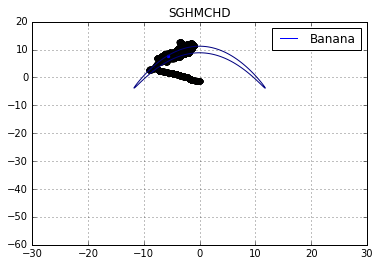

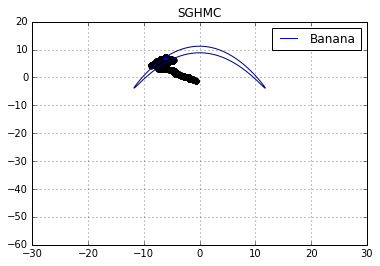

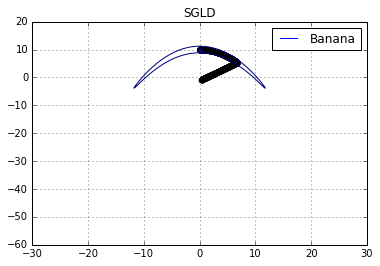

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join("..", "..", "..")))
import numpy as np
from itertools import islice
import matplotlib.pyplot as plt
from keras import backend as K

from pysgmcmc.samplers.sghmc import SGHMCSampler
from pysgmcmc.samplers.relativistic_sghmc import RelativisticSGHMCSampler
from pysgmcmc.samplers.sgld import SGLDSampler
from pysgmcmc.samplers.sghmchd import SGHMCHDSampler

from pysgmcmc.samplers.energy_functions import (
    Banana, Gmm1, Gmm2, Gmm3,
    to_negative_log_likelihood
)
from pysgmcmc.diagnostics import PYSGMCMCTrace

ENERGY_FUNCTIONS = {
    "banana": (
        Banana(),
        lambda: [K.random_normal_variable(shape=(1,), mean=0., scale=1.,), K.random_normal_variable(shape=(1,), mean=0., scale=1.,)],
        lambda samples: plt.scatter(samples[:, 0], samples[:, 1]),
    ),
    "gmm1": (
        Gmm1(),
        lambda: [K.variable(K.random_normal((1,)))],
        lambda samples: plt.hist(samples, normed=True)
    ),
    "gmm2": (
        Gmm2(),
        lambda: [K.variable(K.random_normal((1,)))],
        lambda samples: plt.hist(samples, normed=True)
    ),
    "gmm3": (
        Gmm3(),
        lambda: [K.variable(K.random_normal((1,)))],
        lambda samples: plt.hist(samples, normed=True)
    ),
}

SAMPLERS = (
    SGHMCHDSampler, SGHMCSampler, SGLDSampler, #RelativisticSGHMCSampler
)


def sample(sampler, n_samples=10**4, burn_in_steps=0, keep_every=1):
    _ = list(islice(sampler, burn_in_steps))
    return np.asarray([sample for _, sample in islice(sampler, keep_every, n_samples * keep_every + keep_every)])


energy_function, initial_guess, plot_samples = ENERGY_FUNCTIONS["banana"]

for sampler in SAMPLERS:
    initial_sample = initial_guess()
    loss = to_negative_log_likelihood(energy_function)(initial_sample)
    samples = np.squeeze(sample(sampler(loss=loss, params=initial_sample, lr=0.01, burn_in_steps=3000)))
    energy_function.plot()
    plot_samples(samples)
    plt.title(sampler.__name__)
    plt.show()
